# Ablauf

1) Daten einlesen
2) Daten aufebereiten
    -   Ausreißer identifizieren
3) GSMP-Kenndaten aufbereiten
4) Analyse
    -   Scatterplot Jobs auf Watt + Regression
    -   line chart auf bar chart
    -   Berechnung pro Worker - Idle

# 1. Daten einlesen

### CSV einlesen

<Axes: xlabel='Time'>

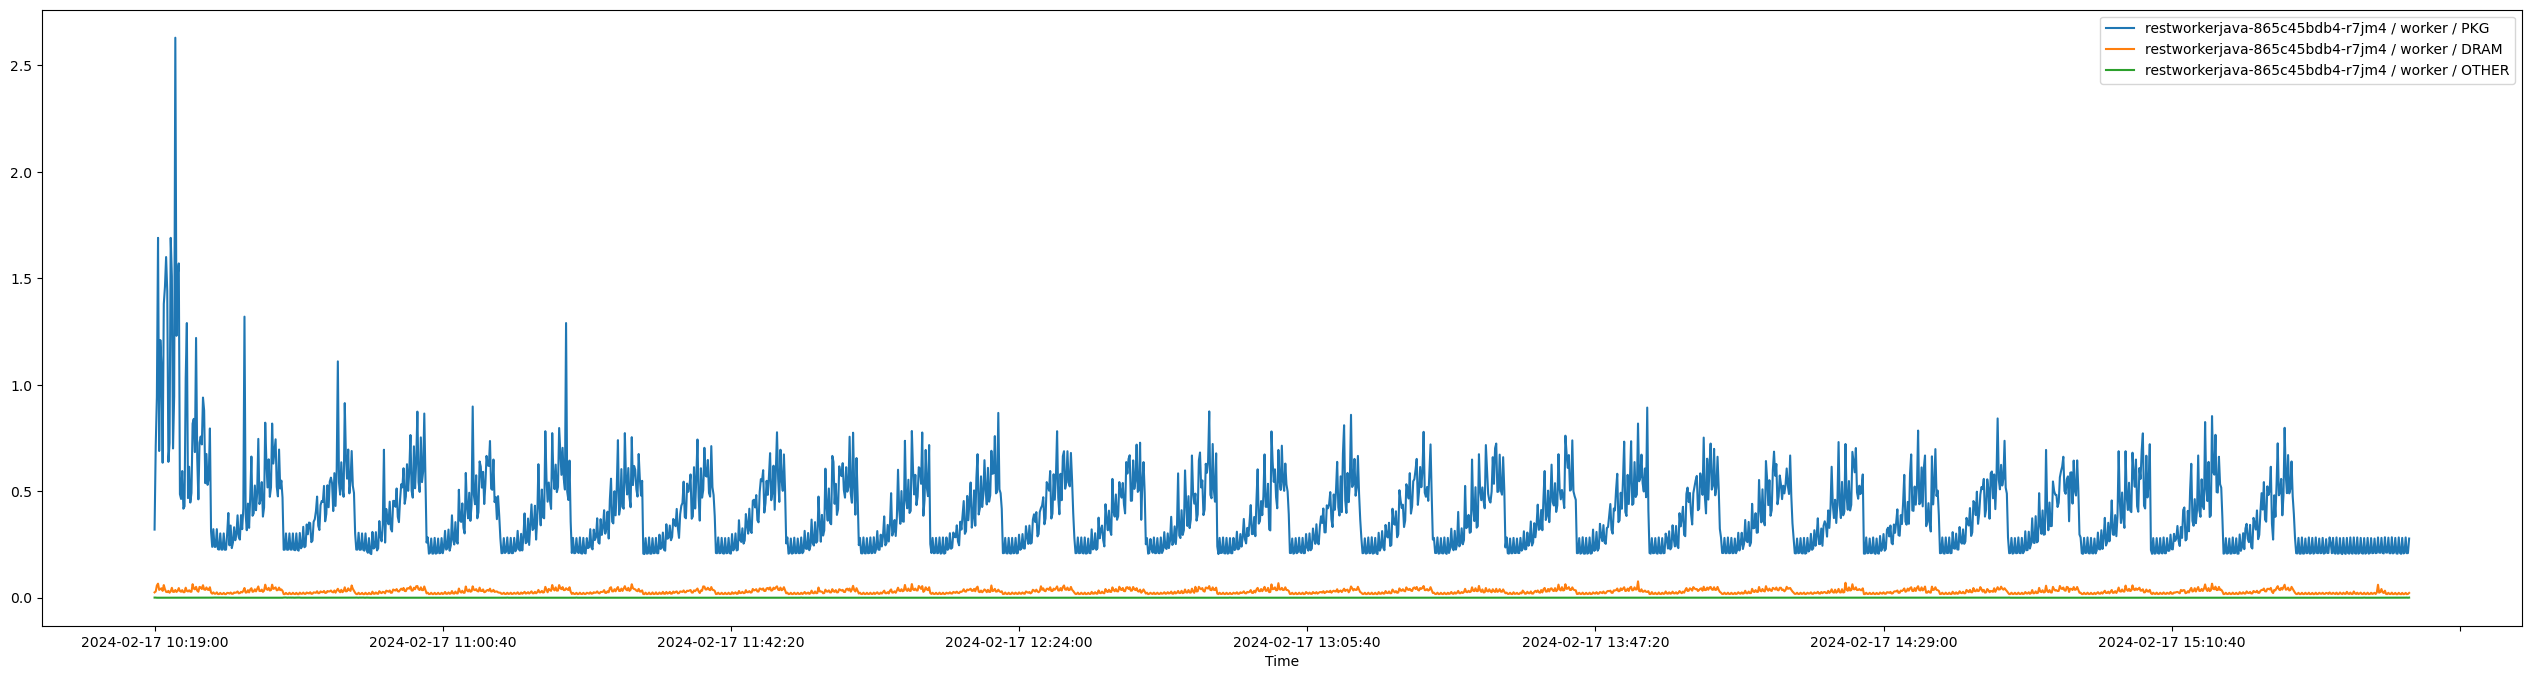

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

#read kepler CSV
worker_power = pd.read_csv("CSV-load-test/2024-02-17 10-19-00 worker power.csv", 
                     header=1, # which row contains column headers
                     index_col=0   ) # which column contains labels
#read zeebe CSV
worker_jobs = pd.read_csv("CSV-load-test/2024-02-17 10-19-00 worker jobs finished.csv", 
                     header=1, # which row contains column headers
                     index_col=0   ) # which column contains labels

worker_power.plot(figsize=[32,8])


# 2. Daten aufbereiten

1) Addiere alle Messwerte von Kepler
2) Generiere Leerlauf-Muster
3) Subtrahiere Leerlauf-Muster

4) Vereine Completion und Power
5) Generiere Durchsatz-Buckets
6) Berechne Outlier pro Bucket

### Messwerte aus Kepler addieren

In [2]:
completion_and_power = pd.DataFrame()

worker_cols = [col for col in worker_power.columns if 'restworkerjava' in col ]

# sum up PKG + DRAM + OTHER for each time stamp
completion_and_power['power'] = worker_power[worker_cols].sum(axis=1)



In [3]:
# drop outliers in front

completion_and_power = completion_and_power.loc['2024-02-05 21:01:00':,:]

### Vereine Completion und Power


<Axes: title={'center': 'Energy Consumption of Worker and corresponding Job Completion'}, xlabel='Time'>

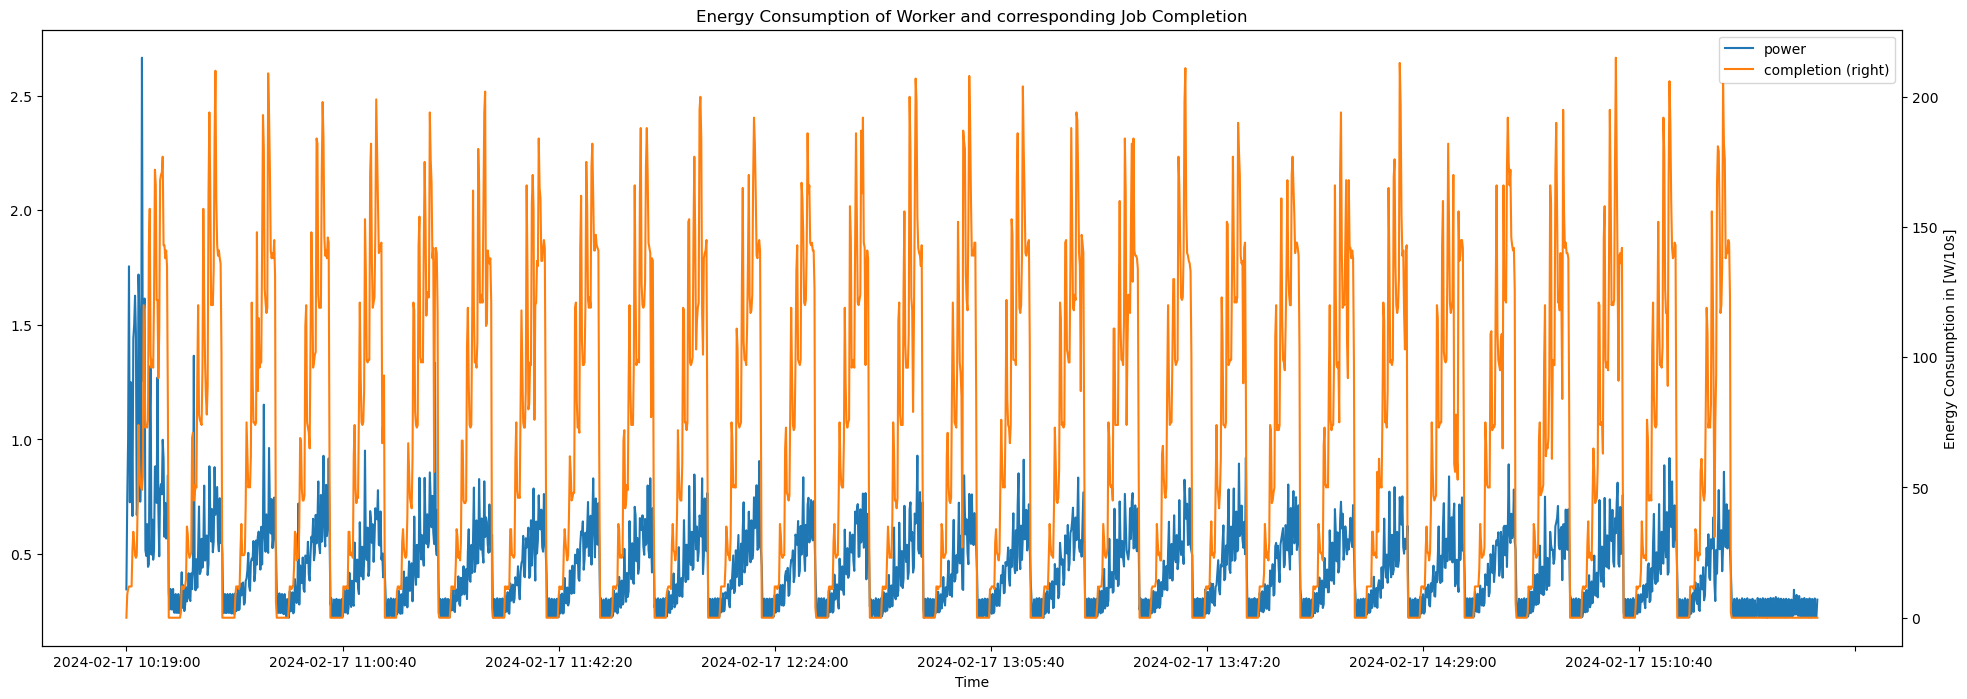

In [4]:
# add job throughput
completion_and_power['completion'] = worker_jobs.iloc[:,0]

# floor job throughput
completion_and_power['completion'] = completion_and_power['completion'] // 1

completion_and_power.plot(
    figsize=[24,8], 
    ylabel='Energy Consumption in [W/10s]',
    secondary_y='completion',
    title='Energy Consumption of Worker and corresponding Job Completion',
    )

### Generiere Leerlauf-Muster + Subtrahiere Leerlauf-Muster

In [5]:
# set all completion >= 1 to NaN

idle_power = completion_and_power.copy()
idle_power[idle_power['completion'] >= 1] = np.nan


# generate medians for 00:00, 00:10, 00:20

# reshape series
idle_pattern = pd.DataFrame(idle_power['power'][:-1].to_numpy().reshape(-1, 3), columns=['00:00', '00:10', '00:20'])

medians = idle_pattern.median(axis=0)

medians


00:00    0.3050
00:10    0.2265
00:20    0.2277
dtype: float64

In [6]:
def remove_idle_power(df, pattern):
    pattern_series = pd.Series()
    
    difference = 0
    
    # repeat the pattern until length of df.index is reached
    while len(pattern_series) < len(df.index):
        pattern_series = pd.concat([pattern_series, pattern])
        difference = len(pattern_series) - len(df.index)
    
    print(difference)

    pattern_series = pattern_series[:-difference]
    pattern_series.index = df.index

    pattern_series = pattern_series.apply(pd.to_numeric, errors='coerce')

    df['no_idle'] = df['power'] - pattern_series
    df['idle'] = pattern_series


    return df

cap_no_idle = remove_idle_power(completion_and_power, medians)

cap_no_idle


2


,power,completion,no_idle,idle
Time,,,,
2024-02-17 10:19:00,0.3458,0.0,0.0408,0.3050
2024-02-17 10:19:10,0.7440,9.0,0.5175,0.2265
2024-02-17 10:19:20,1.0003,11.0,0.7726,0.2277
2024-02-17 10:19:30,1.7560,12.0,1.4510,0.3050
2024-02-17 10:19:40,0.7259,12.0,0.4994,0.2265
...,...,...,...,...
2024-02-17 15:44:20,0.2274,0.0,-0.0003,0.2277
2024-02-17 15:44:30,0.3061,0.0,0.0011,0.3050
2024-02-17 15:44:40,0.2264,0.0,-0.0001,0.2265


### Generiere Durchsatz pro Job

In [7]:
cap_no_idle['per_job_no_idle'] = cap_no_idle['no_idle'] / cap_no_idle['completion']

### Entferne Leerlauf-Werte

In [8]:
cap_no_idle = cap_no_idle[cap_no_idle['completion'] >= 1]

# sort df
cap_sorted = cap_no_idle.sort_values(by='completion')

## Generiere Durchsatz-Buckets pro Job


In [9]:
# Bucket Params

bucket_size = 21

# create limits for buckets
max_throughput = int(cap_sorted['completion'].max())
min_throughput = int(cap_sorted['completion'].min())
span_throughput = int(max_throughput - min_throughput)

# number of buckets
num_buckets = (span_throughput // bucket_size) + 1

In [10]:
# create new df
cap_grouped = pd.DataFrame()
temp_cols = []
xlabels= []

# create df holding idle info
idle_grouped = pd.DataFrame()

# create list of buckets
cap_grouped_list = [cap_sorted[
                            (cap_sorted['completion'] >= (max_throughput - i - bucket_size))
                            & 
                            (cap_sorted['completion'] < (max_throughput - i )) 
                            ] 
                            for i in range(0, span_throughput, bucket_size)
                    ]

# reverse list
cap_grouped_list.reverse()

# create list of bucket labels
bucket_labels = [f"{cap_sorted['completion'][i]} Jobs/s" for i in range(0, len(cap_sorted), bucket_size)]


# consolidate into single df
for  i, b in enumerate(cap_grouped_list):

    # add bucket to per-job df
    cap_grouped = pd.concat([cap_grouped, b['per_job_no_idle'].reset_index(drop=True)], axis=1)

    # add bucket to idle df
    idle_grouped = pd.concat([idle_grouped, b['idle'].reset_index(drop=True)], axis=1)
    temp_cols.append(i * bucket_size)
    xlabels.append(f"{b['completion'].min()} - {b['completion'].max()}")


# format per-job df
cap_grouped = cap_grouped.apply(pd.to_numeric, errors='coerce')
cap_grouped.columns = temp_cols

# format idle df
idle_grouped = idle_grouped.apply(pd.to_numeric, errors='coerce')
idle_grouped.columns = temp_cols

xlabels


['1.0 - 4.0',
 '5.0 - 25.0',
 '26.0 - 46.0',
 '47.0 - 67.0',
 '68.0 - 88.0',
 '89.0 - 109.0',
 '110.0 - 130.0',
 '131.0 - 151.0',
 '152.0 - 172.0',
 '173.0 - 193.0',
 '194.0 - 213.0']

### Prüfe Bucket Size

In [11]:
has_more_than_30_values = pd.Series([len(cap_grouped[column].dropna()) for column in cap_grouped.columns], index=cap_grouped.columns)

# Display the Series
print(has_more_than_30_values)

0       12
21     300
42     131
63     121
84     176
105    156
126    177
147    197
168     95
189     59
210     26
dtype: int64


### Entferne Ausreißer

In [12]:
def filter_outliers_iqr_per_column(column, multiplier=1.5):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    outliers = ((column < lower_bound) | (column > upper_bound))
    return column[~outliers]

# Function to apply the IQR method for each row in a DataFrame
def filter_outliers_iqr(df, multiplier=1.5):
    return df.apply(filter_outliers_iqr_per_column, axis=0).apply(pd.to_numeric, errors='coerce')


cap_clean = filter_outliers_iqr(cap_grouped)

## Generiere Durchsatz-Buckets Gesamtverbrauch (ohne Idle)

In [13]:
# create new df
total_grouped = pd.DataFrame()
temp_cols_total = []


# create list of buckets
total_grouped_list = [cap_sorted[
                            (cap_sorted['completion'] > (max_throughput - i - bucket_size))
                            & 
                            (cap_sorted['completion'] <= (max_throughput - i )) 
                            ] 
                            for i in range(0, span_throughput, bucket_size)
                    ]

# reverse list
total_grouped_list.reverse()

# create list of bucket labels
bucket_labels = [f"{cap_sorted['completion'][i]} Jobs/s" for i in range(0, len(cap_sorted), bucket_size)]


# consolidate into single df
for  i, b in enumerate(total_grouped_list):
    total_grouped = pd.concat([total_grouped, b['no_idle'].reset_index(drop=True)], axis=1)
    temp_cols_total.append(i * bucket_size)

total_grouped = total_grouped.apply(pd.to_numeric, errors='coerce')


temp_cols_total
total_grouped.columns = temp_cols_total

total_grouped_list[10]

,power,completion,no_idle,idle,per_job_no_idle
Time,,,,,
2024-02-17 15:05:00,0.7389,195.0,0.4339,0.3050,0.002225
2024-02-17 12:09:30,0.6682,195.0,0.3632,0.3050,0.001863
2024-02-17 14:56:00,0.6293,195.0,0.3243,0.3050,0.001663
2024-02-17 14:24:40,0.6752,197.0,0.4487,0.2265,0.002278
2024-02-17 12:51:20,0.6809,198.0,0.4532,0.2277,0.002289
2024-02-17 13:43:00,0.8243,198.0,0.5193,0.3050,0.002623
2024-02-17 10:56:50,0.6907,198.0,0.4630,0.2277,0.002338
2024-02-17 11:07:10,0.6583,199.0,0.4318,0.2265,0.002170
2024-02-17 12:09:40,0.6536,200.0,0.4271,0.2265,0.002135


### Entferne Ausreißer

In [14]:
def filter_outliers_iqr_per_column(column, multiplier=1.5):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    outliers = ((column < lower_bound) | (column > upper_bound))
    return column[~outliers]

# Function to apply the IQR method for each row in a DataFrame
def filter_outliers_iqr(df, multiplier=1.5):
    return df.apply(filter_outliers_iqr_per_column, axis=0).apply(pd.to_numeric, errors='coerce')

total_clean = filter_outliers_iqr(total_grouped)

### Plot Result

In [15]:
# define Colors

lightgreen = "#6ccbb2"
green = "#437e6e"
darkblue = "#90c5e2"
blue = "#a2d8ff"
black = "#1f1f1f"
grey = "#f3f3f2"
white = "#ffffff"

[Text(1, 0, '1.0 - 4.0'),
 Text(2, 0, '5.0 - 25.0'),
 Text(3, 0, '26.0 - 46.0'),
 Text(4, 0, '47.0 - 67.0'),
 Text(5, 0, '68.0 - 88.0'),
 Text(6, 0, '89.0 - 109.0'),
 Text(7, 0, '110.0 - 130.0'),
 Text(8, 0, '131.0 - 151.0'),
 Text(9, 0, '152.0 - 172.0'),
 Text(10, 0, '173.0 - 193.0'),
 Text(11, 0, '194.0 - 213.0')]

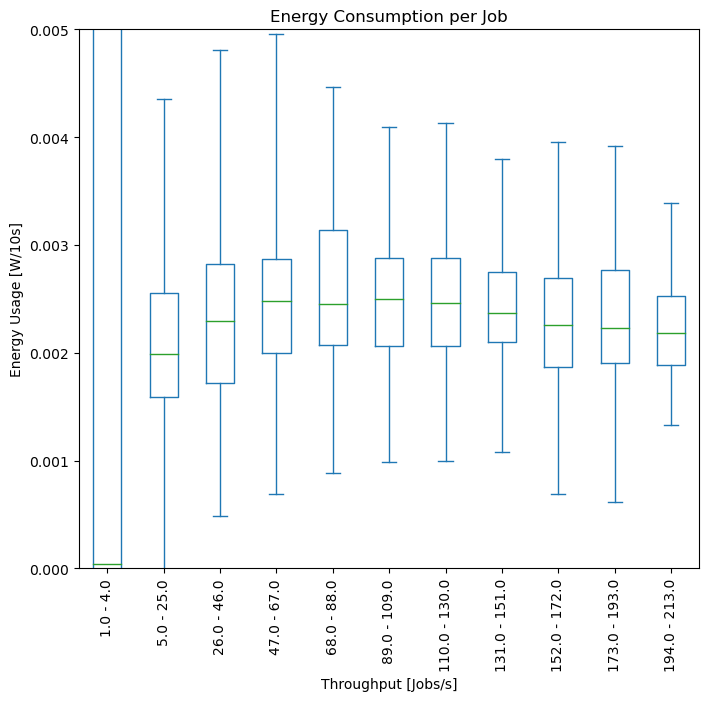

In [27]:
figsize = [15,5]

ax = cap_clean.plot(
        kind='box',
        figsize=[8,7],
        rot = 90, 
        whis=[0,100],
        title="Energy Consumption per Job",
        xlabel="Throughput [Jobs/s]",
        ylabel="Energy Usage [W/10s]",
        ylim=[0,0.005]
)
ax.set_xticklabels(xlabels)

,0,21,42,63,84,105,126,147,168,189,210
0,-0.0033,NaN,0.1206,0.0922,0.2200,0.3032,0.2250,0.3289,0.4920,0.3021,0.4339
1,0.0000,NaN,0.1189,0.0964,0.1453,0.1154,0.3929,0.3577,NaN,0.5277,0.3632
2,NaN,0.0020,0.0576,0.1183,0.2617,0.3359,0.1101,NaN,0.2162,0.5865,0.3243
3,NaN,0.0021,0.0467,0.0987,0.1204,0.2148,0.1729,0.3428,0.3893,0.4999,0.4487
4,-0.0001,0.0099,0.0340,0.0904,0.1347,0.3001,0.3153,0.3119,0.4657,0.4872,0.4532
...,...,...,...,...,...,...,...,...,...,...,...
294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
295,NaN,0.0162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
296,NaN,0.0408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
297,NaN,0.0636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


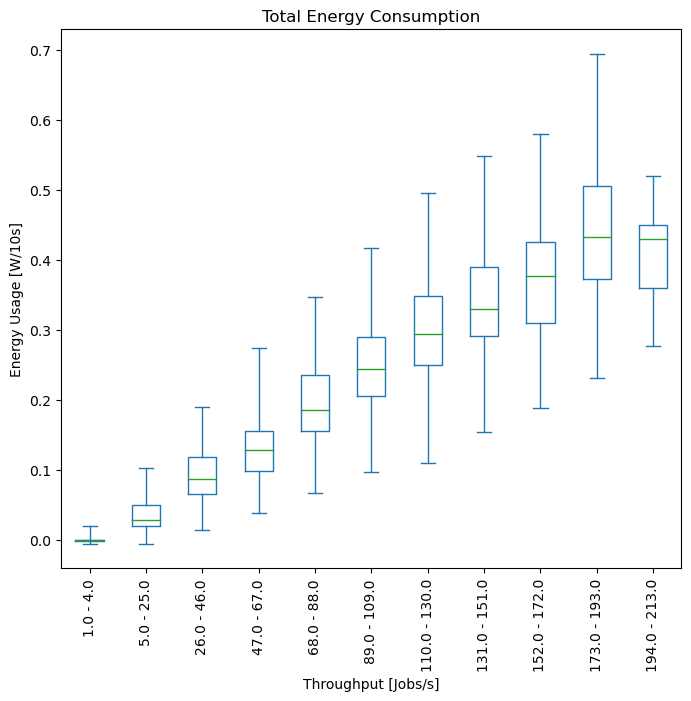

In [17]:
ax = total_clean.plot(
        kind='box',
        figsize=[8,7],
        rot = 90, 
        whis=[0,100],
        title="Total Energy Consumption",
        xlabel="Throughput [Jobs/s]",
        ylabel="Energy Usage [W/10s]"
)
ax.set_xticklabels(xlabels)

total_clean

3.750000000000281e-05 0.002495959595959596 66.55892255891759


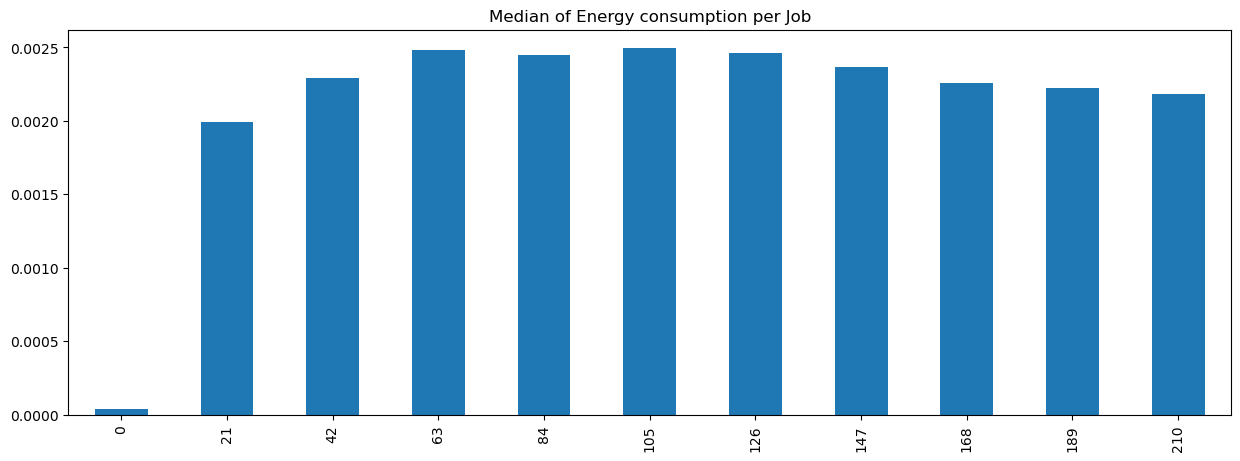

In [18]:
cap_clean.median(axis=0).plot(
    kind='bar',
    figsize=figsize,
    title='Median of Energy consumption per Job'
)

min_med = cap_clean.median(axis=0).min()
max_med = cap_clean.median(axis=0).max()

print(min_med, max_med, max_med/min_med)

-9.999999999998899e-05 0.432 -4320.000000000476
0.25921276046056835
0     -0.00010
21     0.02840
42     0.08725
63     0.12820
84     0.18500
105    0.24415
126    0.29455
147    0.32930
168    0.37625
189    0.43200
210    0.42945
dtype: float64


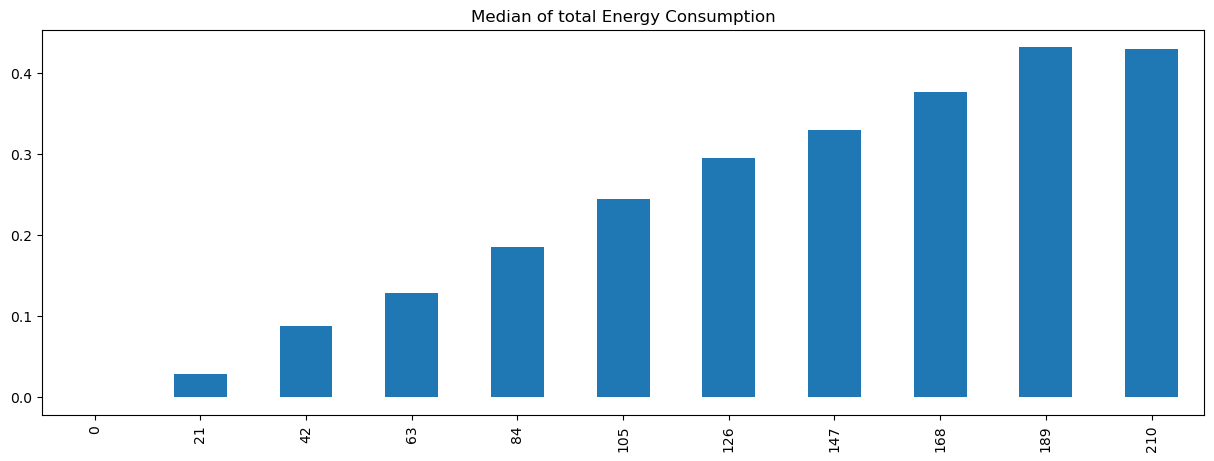

In [19]:
total_clean.median(axis=0).plot(
    kind='bar',
    figsize=figsize,
    title="Median of total Energy Consumption"
)

min_med = total_clean.median(axis=0).min()
max_med = total_clean.median(axis=0).max()

print(min_med, max_med, max_med/min_med)
print(idle_pattern.mean().mean())
print(total_clean.median(axis=0))


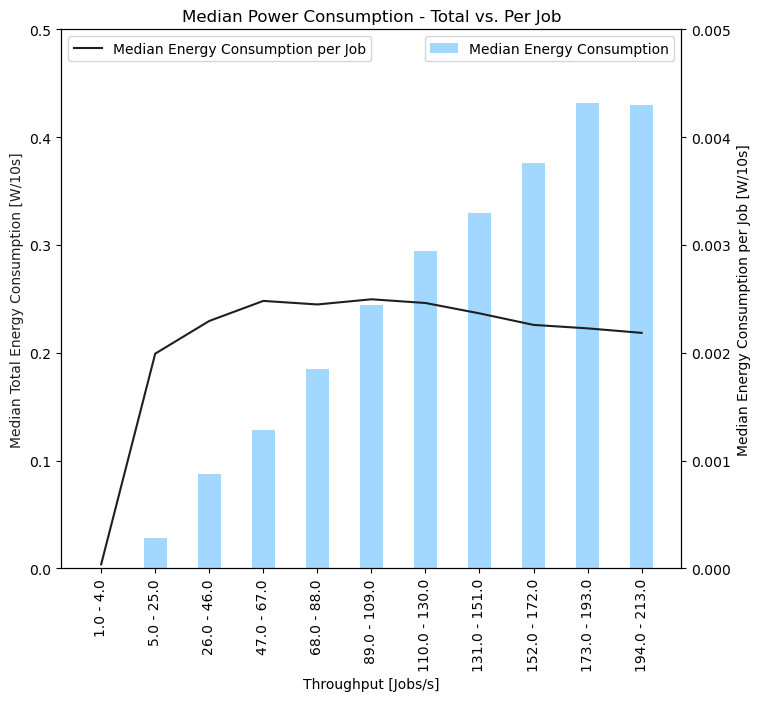

In [20]:
# Create a figure and axis for the first series
fig, ax1 = plt.subplots(figsize=[8,7])

xlabel_pos = [range(0,num_buckets)]

# Plot the first series as a line graph
ax1.bar(total_clean.median().index, 
        total_clean.median().values, 
        color= blue, 
        width=9,
        label='Median Energy Consumption'
        )

# Add labels and legend for the first y-axis
ax1.set_xlabel('Throughput [Jobs/s]')
ax1.set_ylabel('Median Total Energy Consumption [W/10s]', color=black)
ax1.legend(loc='upper right')

ax1.set_xticks(total_clean.median().index)
ax1.set_xticklabels(xlabels, rotation=90)


# Create a secondary y-axis for the second series
ax2 = ax1.twinx()

# Plot the second series as a bar chart
ax2.plot(cap_clean.median().index, 
         cap_clean.median().values, 
         label='Median Energy Consumption per Job', 
         color=black,
         )

# Add labels and legend for the second y-axis
ax2.set_ylabel('Median Energy Consumption per Job [W/10s]')
ax2.legend(loc='upper left')
ax1.set_ylim(0,0.5)
ax2.set_ylim(0,0.005)

ax1.set_title("Median Power Consumption - Total vs. Per Job")
# Show the plot

plt.show()

In [21]:
idle_grouped

,0,21,42,63,84,105,126,147,168,189,210
0,0.2277,0.2277,0.2265,0.3050,0.2265,0.2265,0.2277,0.2277,0.2265,0.2265,0.3050
1,0.2277,0.2265,0.2277,0.2265,0.2277,0.2265,0.2265,0.2265,0.2277,0.2265,0.3050
2,0.2277,0.2277,0.3050,0.2277,0.2277,0.3050,0.2277,0.2277,0.2277,0.2265,0.2265
3,0.2265,0.2277,0.3050,0.2265,0.2265,0.2265,0.2265,0.2277,0.2277,0.2265,0.3050
4,0.2265,0.3050,0.3050,0.2277,0.2277,0.3050,0.3050,0.3050,0.3050,0.3050,0.2265
...,...,...,...,...,...,...,...,...,...,...,...
295,NaN,0.2277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
296,NaN,0.2265,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
297,NaN,0.3050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
298,NaN,0.2277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


idle     float64
total    float64
dtype: object


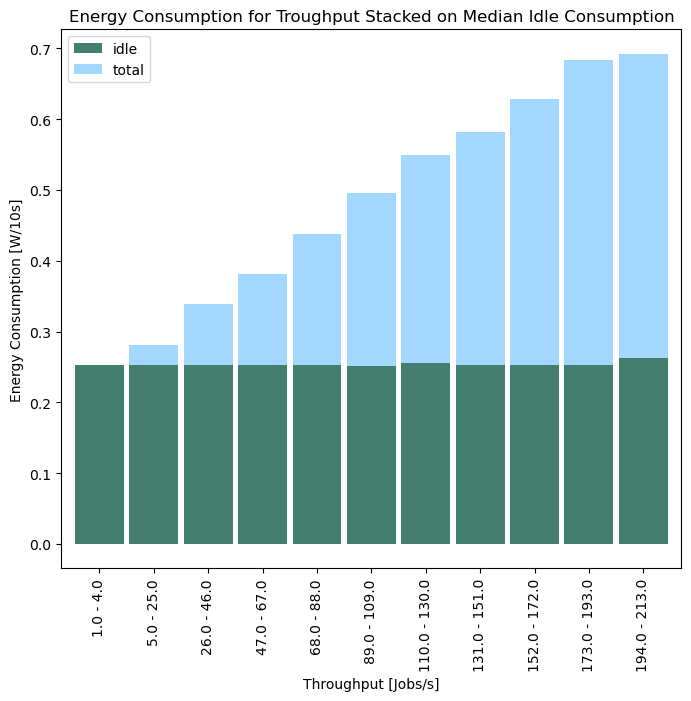

In [22]:
temp = pd.DataFrame()
temp['total'] = total_clean.median().reset_index(drop=True)
temp['idle'] = idle_grouped.mean(skipna=True).reset_index(drop=True)
# temp['per_worker'] = cap_clean.median().reset_index(drop=True)

# Reverse the order of columns
temp = temp[temp.columns[::-1]]

temp.index = xlabels
print(temp.dtypes)
ax1 = temp.plot(
    figsize=[8,7],
    kind='bar',
    stacked=True,
    color=[green,blue],
    width=0.9,
    title="Energy Consumption for Troughput Stacked on Median Idle Consumption",
    xlabel="Throughput [Jobs/s]",
    ylabel="Energy Consumption [W/10s]"
)

['1.0 - 4.0', '5.0 - 25.0', '26.0 - 46.0', '47.0 - 67.0', '68.0 - 88.0', '89.0 - 109.0', '110.0 - 130.0', '131.0 - 151.0', '152.0 - 172.0', '173.0 - 193.0', '194.0 - 213.0']


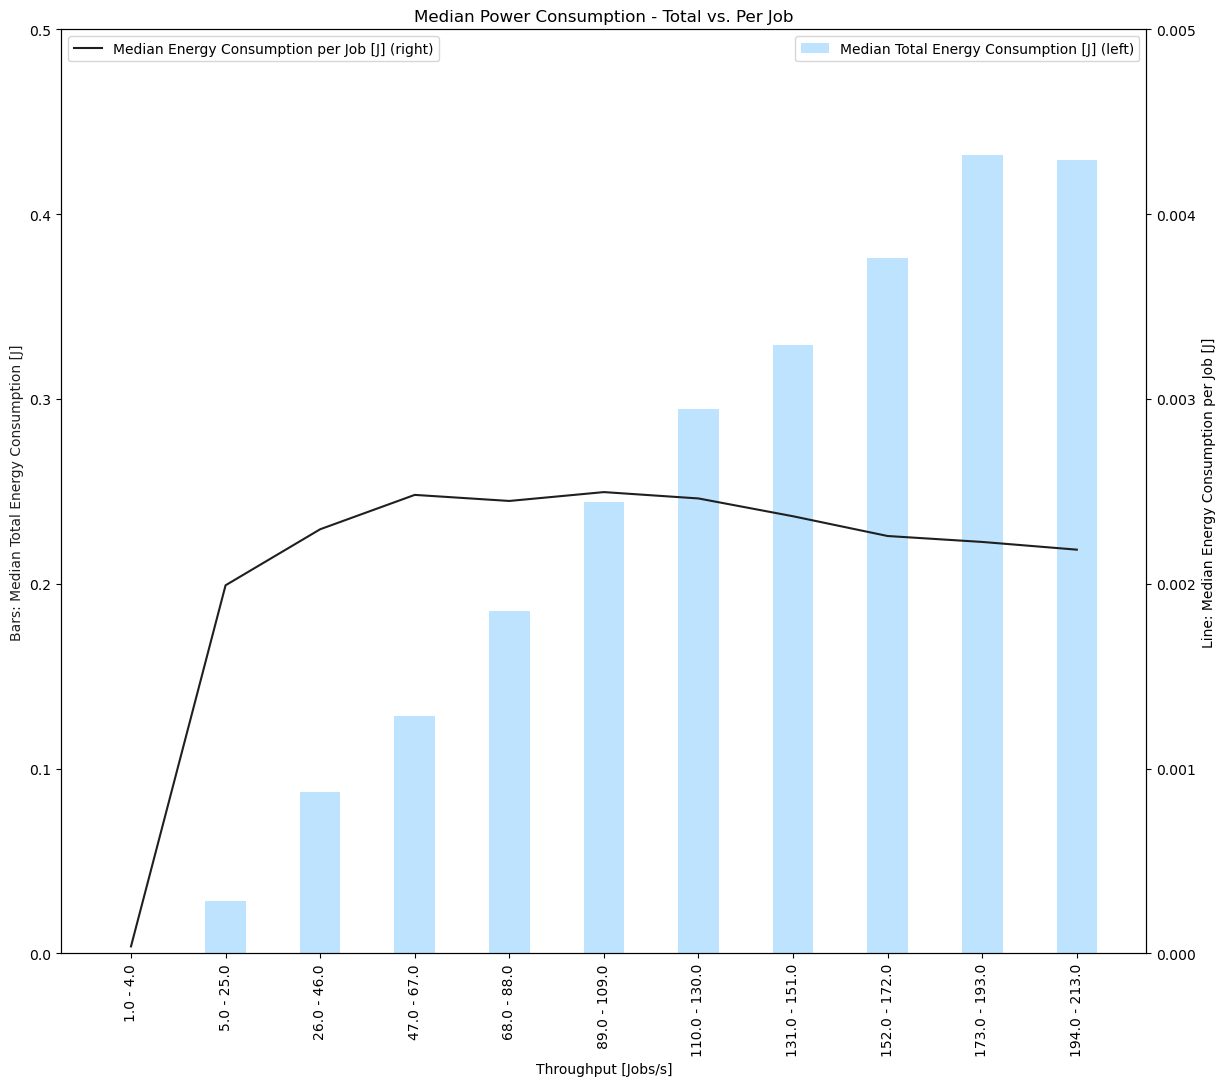

In [23]:
# Create a figure and axis for the first series
fig, ax1 = plt.subplots(figsize=[14,12])

xlabel_pos = [range(0,num_buckets)]

# Plot the first series as a line graph
ax1.bar(total_clean.median().index, 
        total_clean.median().values, 
        label='Median Total Energy Consumption [J] (left)', 
        color= blue, 
        alpha=0.7,
        width=9, 
        )

# Add labels and legend for the first y-axis
ax1.set_xlabel('Throughput [Jobs/s]')
ax1.set_ylabel('Bars: Median Total Energy Consumption [J]', color=black)
ax1.legend(loc='upper right')
print(xlabels)
ax1.set_xticks(total_clean.median().index)
ax1.set_xticklabels(xlabels, rotation=90)


# Create a secondary y-axis for the second series
ax2 = ax1.twinx()

# Plot the second series as a bar chart
ax2.plot(cap_clean.median().index, 
         cap_clean.median().values, 
         label='Median Energy Consumption per Job [J] (right)', 
         color=black
         )

# Add labels and legend for the second y-axis
ax2.set_ylabel('Line: Median Energy Consumption per Job [J]')
ax2.set_ylim(0,0.005)
ax1.set_ylim(0,0.5)
ax2.legend(loc='upper left')

ax1.set_title("Median Power Consumption - Total vs. Per Job")
# Show the plot

plt.show()

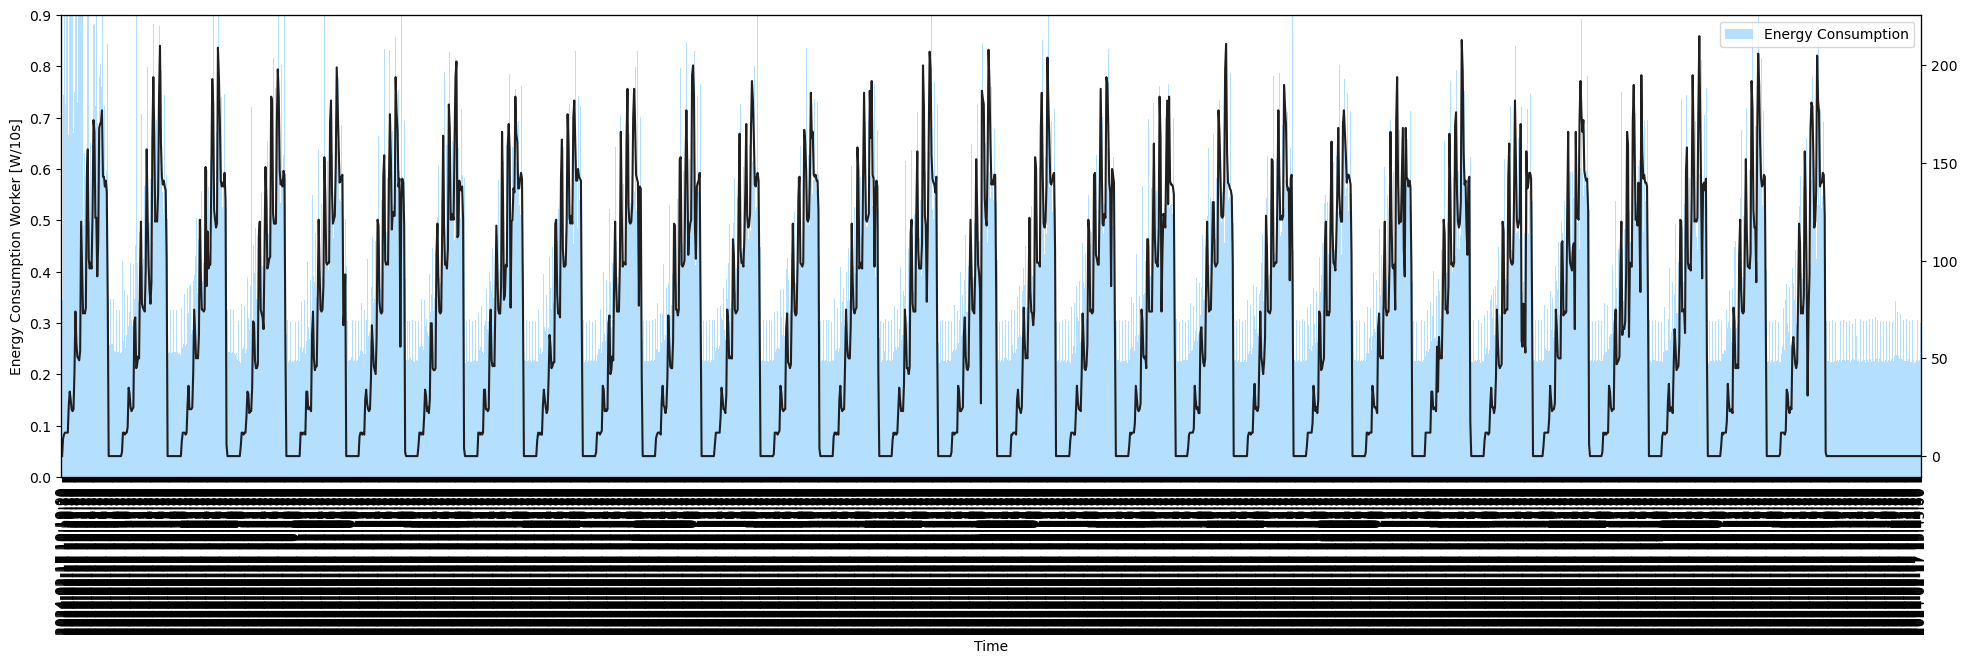

In [24]:
# Plot completion and power as time series
figsize= [24,6]


# Plotting
ax = completion_and_power['power'].plot(
    kind='bar',
    width=1,
    alpha=0.8,
    color= blue, 
    label='Energy Consumption',
    ylim=[0,0.9],
    xticks=None,
    figsize=figsize
    )

ax.set_ylabel('Energy Consumption Worker [W/10s]')

# Create secondary y-axis
ax2 = ax.twinx()
completion_and_power['completion'].plot(
    ax=ax2, 
    color=black, 
    label='Job Completion',
    xticks=None,
    secondary_y=True)
ax2.set_ylabel('Job Completion [1/s]')

# Combine legends
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='upper right')

plt.show()

<Axes: xlabel='Time'>

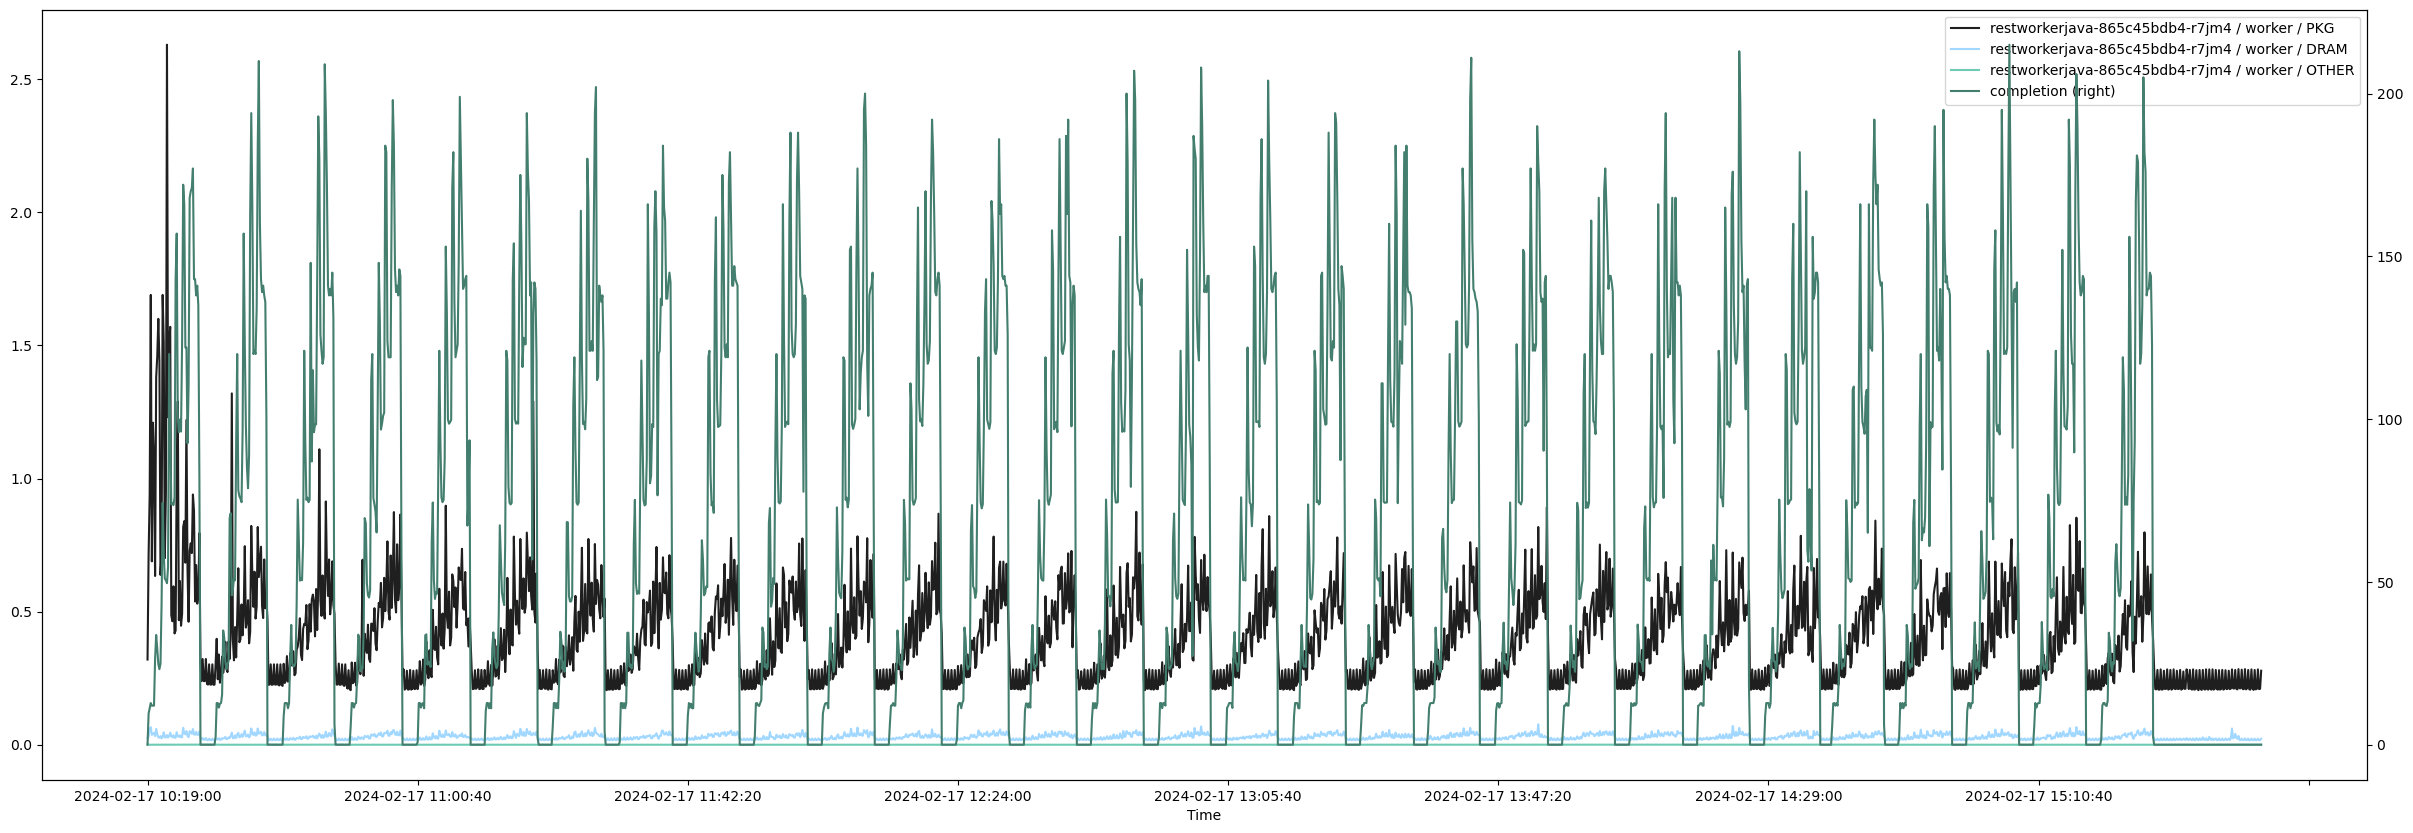

In [25]:
# raw plot

raw_plot = pd.DataFrame(worker_power.loc['2024-02-05 21:01:00':,:])
raw_plot['completion'] = worker_jobs

raw_plot.plot(secondary_y='completion', color=[black, blue, lightgreen, green], figsize=[30,10])

In [26]:
# create Table with Key Indicators

indicators = pd.DataFrame(columns = ['Energieverbrauch', 'Durchsatz'])

indicators.loc['Minimum', 'Energieverbrauch'] = completion_and_power['power'].min()
indicators.loc['Maximum', 'Energieverbrauch'] = completion_and_power['power'].max()
indicators.loc['Minimum', 'Durchsatz'] = completion_and_power['completion'].min()
indicators.loc['Maximum', 'Durchsatz'] = completion_and_power['completion'].max()

indicators

,Energieverbrauch,Durchsatz
Minimum,0.2221,0.0
Maximum,2.6663,215.0


---
### Messvorbereitung

Zeebe Dashboard importieren
Skript vorbereiten (Prozessname, Array, etc)
Prozess deployen
Zeebe Port-Forwarding
Timestamp setzen

### Messnachbereitung

Grafana CSV-Export

### ToDo

Skript ändern, so dass Logs Startzeitpunkte in 1 File schreiben
Modulo in shellskript-methode anpassen weil alter scrape intervall war 10sek, jetzt sinds 30Sek

### Notizen

Startzeitpunkt: 2024-02-01 11:40:00 
Modell: load_generator_120j_in_60s

maxjobsactive: 32
pollinterval: 2 # seconds before polling again
timeout: 45
requestTimeout: 30 # how long to keep a request open

---
